## Train Model

In [5]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import Counter
from utils import mysqlDatabase
from myBertTools import myBertModel, myTokenizer
from sklearn.model_selection import train_test_split

In [6]:
def seq_padding(X, padding=0):
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])

In [7]:
class dataPrepare:
    def __init__(self, model_output_path, label_dic_name, sample_N, test_size, random_state):
        self.model_output_path = model_output_path
        self.label_dic_name = label_dic_name
        self.sample_N = sample_N
        self.test_size = test_size
        self.random_state = random_state
    def get_long_data(self, postid, type, title, excerpt, topics, result):
        for label in topics:
            result.append([postid, type, title, excerpt, label])
    def regex(self, text):
        return text.replace("'", '').replace("[", '').replace("]", '').replace(" ", '').split(',')
    def get_multi_label_set(self, df):
        # 看板名稱
        forum_list = df.name.unique().tolist()
        # 整理樣本數大於N的標籤名單
        label_list = np.concatenate(df.topics.apply(self.regex).tolist())
        df_label = pd.DataFrame.from_dict(dict(Counter(label_list)), orient='index', columns=['count']).reset_index()
        df_label.columns = ['label', 'count']
        df_label = df_label[(df_label['count'] >= sample_N) & (df_label['label'] != '')]
        label_list = df_label.label.tolist()
        # 合併看板名單、標籤名單
        label_set = set(np.concatenate([label_list, forum_list]))
        return label_set
    def get_train_test_split(self, df):
        df_t, df_v,= train_test_split(df, test_size = test_size, random_state = random_state, stratify = df.name)
        df_t['type'] = 'train'
        df_v['type'] = 'valid'
        df = pd.concat([df_t, df_v], sort=True)
        df = df.reset_index(drop=True)
        return df
    def save_label_dic(self, df):
        label_list = list(df.columns)
        label_dic = {i : label_list[i] for i in range(0, len(label_list))}
        label_site = model_output_path + label_dic_name
        np.save(label_site, label_dic)
    def get_data_multi_label(self, MysqlDatabase, sql): 
        df = MysqlDatabase.select_table(sql)  
        # split train/test data set
        df = self.get_train_test_split(df)
        # get multi label set
        label_set = self.get_multi_label_set(df)
        # label preparation
        df.topics = df.topics.apply(self.regex)
        df.apply(lambda x: x.topics.append(x['name']), axis=1)
        df = df[['id', 'name', 'title', 'excerpt', 'topics', 'type']].drop_duplicates(subset = 'id')
        df.topics = df.topics.apply(lambda x: list(set(x)))
        df.topics = df.topics.apply(lambda x: set(x).intersection(label_set))
        # one-hot encoding for multi label
        result = []
        df.apply(lambda x: self.get_long_data(x['id'], x.type, x.title, x.excerpt, x.topics, result), axis=1)
        df = pd.DataFrame(result, columns = ['id', 'type', 'title', 'excerpt', 'label'])
        df['text'] = df['title'] + ' ' + df['excerpt']
        df['value'] = 1
        df1 = pd.pivot_table(df, index=['id', 'text', 'type'], columns='label', values='value', fill_value=0)
        # save label dic
        self.save_label_dic(df1)
        # final training data format
        df = df1.reset_index(drop=False)
        Y_df = df1.reset_index(drop=True)
        return df, Y_df

In [8]:
class dataGenerator:
    def __init__(self, data, batch_size=32):
        self.data = data
        self.batch_size = batch_size
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
    def __len__(self):
        return self.steps
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
            np.random.shuffle(idxs)
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = MyTokenizer.encode(first=text)
                y = d[1:]
                X1.append(x1)
                X2.append(x2)
                Y.append(y)
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y
                    [X1, X2, Y] = [], [], []

In [9]:
if __name__ == '__main__':
    # set parameter
    sample_N = 100
    test_size = 0.1
    random_state = 37
    maxlen = 100
    epochs_N = 3
    os.environ['TF_KERAS'] = '1'
    pretrained_path = '/Users/jackyfu/Desktop/hwf87_git/bert_wwm/'
    config_path = os.path.join(pretrained_path, 'bert_config.json')
    checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
    vocab_path = os.path.join(pretrained_path, 'vocab.txt')
    label_dic_name = 'dcard_cate_multi_label_dic.npy'
    model_name = 'dcard_post_multi_cls_bert.h5'
    model_output_path = '/Users/jackyfu/Desktop/hwf87_git/Dcard_post_classification/model_output/'
    my_forums_list = ['時事', '網路購物', '股票', '美妝', '工作', '考試', '穿搭', '3C', 'Apple', '感情', 
                      '美食', '理財', '居家生活', '臺灣大學', 'YouTuber']
    with open('config.yml', 'r') as stream:
        myconfig = yaml.load(stream, Loader=yaml.CLoader)
    database_username = myconfig['mysql_database']['database_username']
    database_password = myconfig['mysql_database']['database_password']
    database_ip       = myconfig['mysql_database']['database_ip']
    database_name     = myconfig['mysql_database']['database_name']
    MysqlDatabase = mysqlDatabase(database_username, database_password, database_ip, database_name)
    sql = '''
    SELECT df.name, dp.*
    FROM Bigdata.dcard_posts dp
    left join Bigdata.dcard_forums df on dp.forumid = df.id
    WHERE 1=1
    and df.name in :my_forums_list
    '''
    sql = sql.replace(':my_forums_list', str(tuple(my_forums_list)))
    ## prepare data format
    DataPrepare = dataPrepare(model_output_path, label_dic_name, sample_N, test_size, random_state)
    df, Y_df = DataPrepare.get_data_multi_label(MysqlDatabase, sql)
    ## build model
    MyBertModel = myBertModel(pretrained_path, config_path, checkpoint_path, vocab_path)
    token_dict = MyBertModel.get_token_dict()
    model = MyBertModel.build_model(Y_df)
    MyTokenizer = myTokenizer(token_dict)
    ## Training and save model
    train_data = df[df['type'] == 'train'].drop(columns=['id', 'type']).values.tolist()
    valid_data = df[df['type'] == 'valid'].drop(columns=['id', 'type']).values.tolist()
    train_D = dataGenerator(train_data)
    valid_D = dataGenerator(valid_data)

    history = model.fit(
        train_D.__iter__(),
        steps_per_epoch=len(train_D),
        epochs=epochs_N,
        validation_data=valid_D.__iter__(),
        validation_steps=len(valid_D)
    )
    model.save(model_output_path + model_name)

Successfully select from Bigdata table


/var/folders/17/dsyzw2j96ggfgmrjcsnbtz700000gn/T/ipykernel_66008/152716144.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['type'] = 'train'
/var/folders/17/dsyzw2j96ggfgmrjcsnbtz700000gn/T/ipykernel_66008/152716144.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['type'] = 'valid'
2021-09-06 23:00:41.784848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been b

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, 768)    101677056   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)

2021-09-06 23:00:44.772408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-06 23:00:44.772598: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-09-06 23:00:49.136843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


554/554 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.2885

2021-09-06 23:37:47.166231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


554/554 [==============================] - 2314s 4s/step - loss: 0.1046 - accuracy: 0.2885 - val_loss: 0.0587 - val_accuracy: 0.4948
Epoch 2/3
554/554 [==============================] - 2953s 5s/step - loss: 0.0530 - accuracy: 0.4975 - val_loss: 0.0440 - val_accuracy: 0.5274
Epoch 3/3
554/554 [==============================] - 31905s 58s/step - loss: 0.0417 - accuracy: 0.5312 - val_loss: 0.0383 - val_accuracy: 0.5455


/Users/jackyfu/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


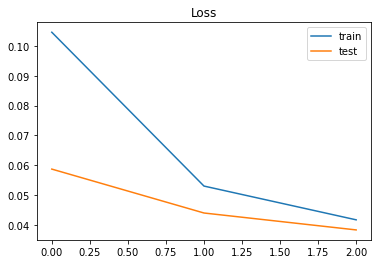

In [10]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()